In [1]:
from model.starnet.starnet_feature import StarNet_MHSA_Feature

In [5]:
import torchvision.transforms as transforms
from PIL import Image
CFG_StarAttn_T2 = {
        'img_size': 192,
        'dims': [32,64,128,256],
        'depth': [1,2,4,5],
        'drop_path_rate': 0,
        'mlp_ratio': 2,
        "act_layer": "GELU",
        "learnable_wavelet": True,
        "down_sample": 32
    }


def StarNet_MHSA_T2_DTW(num_classes=1000, pretrained=False, distillation=False, fuse=False, pretrained_cfg=None, model_cfg=CFG_StarAttn_T2):
    model = StarNet_MHSA_Feature(num_classes=num_classes, distillation=distillation, **model_cfg)
    return model

import torch

img = Image.open(r"C:\Users\Administrator\Desktop\FSANet\supreme-train\n01440764_18.JPEG") # 转为灰度图

transform = transforms.Compose([
        transforms.Resize((192,192)),  # 确保尺寸为2的倍数
        transforms.ToTensor()
])

model = StarNet_MHSA_T2_DTW().cuda().eval()
x = transform(img).cuda().unsqueeze(0)

x = x[:,:3,:,:]
# weight = torch.load('model_weights/StarNet_MHSA_T2_DTW/net_E.pth')
# model.load_state_dict(weight)

LL shape: torch.Size([1, 32, 24, 24])
LH shape: torch.Size([1, 32, 24, 24])


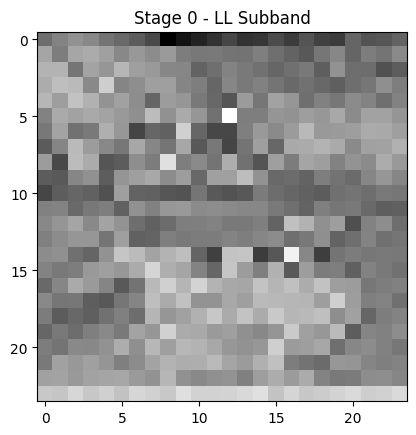

In [6]:
import torch

# model = StarNet_MHSA_T2_DTW().cuda().eval()
# x = torch.randn(1, 3, 256, 256).cuda()

# 获取 stage 0 第一个 WTAttn 的特征
output, feat = model.forward_with_wtattn_features(x, stage_idx=0)

print("LL shape:", feat['ll'].shape)   # [1, C, H/2, W/2]
print("LH shape:", feat['lh'].shape)

# 可视化
import matplotlib.pyplot as plt
ll_map = feat['ll'][0, 0].cpu().detach().numpy()
plt.imshow(ll_map, cmap='gray')
plt.title('Stage 0 - LL Subband')
plt.show()

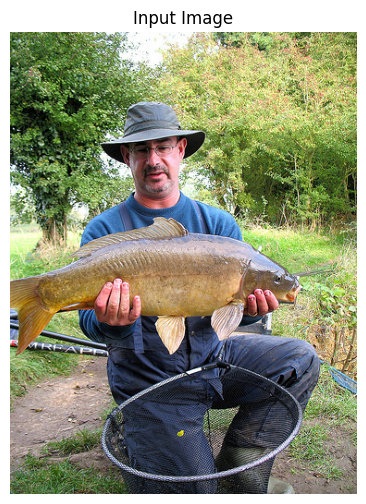

Extracting features from Stage 0...
✅ Saved individual feature: wtattn_visualizations\stage_0_Input_to_WTAttn.png
✅ Saved individual feature: wtattn_visualizations\stage_0_LL_Low_Low.png
✅ Saved individual feature: wtattn_visualizations\stage_0_LH_Low_High.png
✅ Saved individual feature: wtattn_visualizations\stage_0_HL_High_Low.png
✅ Saved individual feature: wtattn_visualizations\stage_0_HH_High_High.png


OSError: [Errno 22] Invalid argument: 'C:\\Users\\Administrator\\Desktop\\FSANet\\supreme-train\\wtattn_visualizations\\stage_0_HL_*_LH.png'

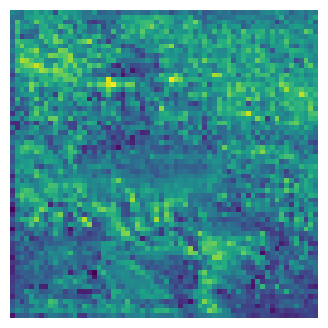

: 

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# 假设你的模型定义在当前文件或已导入
from model.starnet.starnet_feature import StarNet_MHSA_Feature # 替换为你的实际导入路径

# ----------------------------
# 1. 加载真实图像并预处理
# ----------------------------
def load_image(image_path, img_size=256):
    img = Image.open(image_path).convert('RGB')
    transform = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet norm
    ])
    x = transform(img).unsqueeze(0)  # [1, 3, H, W]
    return x, img

# ----------------------------
# 2. 修改模型以支持特征提取（仅需 WTAttn 支持 return_features）
# ----------------------------
# 确保你的 WTAttn.forward 已按之前建议修改（支持 return_features=True）

# ----------------------------
# 3. 提取指定 stage 第一个 WTAttn 的特征（不破坏原模型结构）
# ----------------------------
def extract_wtattn_features(model, x, stage_idx):
    x = model.patch_embed(x)
    blocks_list = [model.blocks1, model.blocks2, model.blocks3, model.blocks4]

    # 前 stage_idx 个 stage：完整前向
    for i in range(stage_idx):
        x = blocks_list[i](x)

    # 在目标 stage 中，找到第一个类型为 'Block' 的模块
    target_stage = blocks_list[stage_idx]
    first_block = None
    pre_layers = []
    for module in target_stage:
        if type(module).__name__ == 'Block':  # ← 关键修改：避免 NameError
            first_block = module
            break
        else:
            pre_layers.append(module)

    if first_block is None:
        raise ValueError(f"No Block found in stage {stage_idx}")

    # 执行该 stage 中 Block 之前的下采样层（如 stride=2 卷积）
    for layer in pre_layers:
        x = layer(x)

    # 手动执行 first_block 直到 WTAttn
    x_shape = x.shape
    if (x_shape[2] % 2 > 0) or (x_shape[3] % 2 > 0):
        x = F.pad(x, (0, x_shape[3] % 2, 0, x_shape[2] % 2))

    x = first_block.DW(x)
    x = first_block.ese(x)
    x = first_block.ffn1(x)

    # 调用 WTAttn 并返回特征
    wtattn_module = first_block.wtattn.m  # Residual 包装的 WTAttn
    _, features = wtattn_module(x, return_features=True)

    return features






# ----------------------------
# 4. 可视化子带特征
# ----------------------------
def visualize_subbands(features, stage_idx, save_dir="wtattn_viz"):
    os.makedirs(save_dir, exist_ok=True)
    subbands = ['input','ll', 'lh', 'hl', 'attn', 'output']
    titles = ['LL (Low-Low)', 'LH (Low-High)', 'HL (High-Low)', 'HH (High-High)', 'Attention (LL modulated)']

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, key in enumerate(subbands):
        feat = features[key][0]  # [C, H, W]
        # 平均所有通道以便可视化
        feat_map = feat.mean(dim=0).cpu().detach().numpy()
        axes[i].imshow(feat_map, cmap='viridis')
        axes[i].set_title(titles[i], fontsize=12)
        axes[i].axis('off')
    
    plt.suptitle(f'Stage {stage_idx} - First WTAttn Subbands', fontsize=16)
    save_path = os.path.join(save_dir, f'stage_{stage_idx}_subbands.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=200)
    plt.show()
    print(f"Saved: {save_path}")


def visualize_all_features(features, stage_idx, original_img=None, save_dir="wtattn_viz"):
    import os
    import matplotlib.pyplot as plt
    os.makedirs(save_dir, exist_ok=True)
    
    keys = ['input', 'll', 'lh', 'hl', "hh", 'hlxlh', '*attn_weight', '*attn_no_+', 'attn', 'output']
    titles = [
        'Input to WTAttn',
        'LL (Low-Low)',
        'LH (Low-High)',
        'HL (High-Low)',
        'HH (High-High)',
        'HL * LH',
        'ATTN_Weight (act(HL * LH))',
        "ATTN_no_+ (act(HL * LH) * LL)",
        'Attention (Modulated LL)',
        'Output of WTAttn'
    ]
    
    # 先保存每个子图单独的 PNG
    for i, key in enumerate(keys):
        feat = features[key]
        if feat.dim() == 4:
            feat_map = feat[0].mean(dim=0).cpu().detach().numpy()
        else:
            raise ValueError(f"Unexpected feature shape for {key}: {feat.shape}")
        
        # 创建单独的 figure
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(feat_map, cmap='viridis')
        # ax.set_title(titles[i], fontsize=12)
        ax.axis('off')
        
        # 构造安全的文件名（避免空格、特殊字符）
        safe_title = titles[i].replace(" ", "_").replace("(", "").replace(")", "").replace("-", "_")
        single_save_path = os.path.join(save_dir, f'stage_{stage_idx}_{safe_title}.png')
        plt.savefig(single_save_path, bbox_inches='tight', dpi=200)
        plt.close(fig)  # 释放内存
        print(f"✅ Saved individual feature: {single_save_path}")
    
    # 可选：再保存一个汇总大图（6个子图拼在一起）
    fig, axes = plt.subplots(1, 10, figsize=(16, 4))
    axes = axes.flatten()
    
    for i, key in enumerate(keys):
        feat = features[key]
        if feat.dim() == 4:
            feat_map = feat[0].mean(dim=0).cpu().detach().numpy()
        else:
            raise ValueError(f"Unexpected feature shape for {key}: {feat.shape}")
        
        axes[i].imshow(feat_map, cmap='viridis')
        axes[i].set_title(titles[i], fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle(f'Stage {stage_idx} - Full WTAttn Feature Visualization', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    save_path = os.path.join(save_dir, f'stage_{stage_idx}_full_features.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=200)
    plt.show()
    print(f"✅ Saved full feature visualization: {save_path}")




# ----------------------------
# 5. 主流程
# ----------------------------
if __name__ == "__main__":
    # 配置
    image_path = r"C:\Users\Administrator\Desktop\FSANet\supreme-train\n01440764_18.JPEG"  # ← 替换为你的图像路径
    model = StarNet_MHSA_T2_DTW(num_classes=1000)
    
    # 如果有预训练权重，加载它
    # weight = torch.load('model_weights/StarNet_MHSA_T2_DTW/net_E.pth')
    # model.load_state_dict(weight)

    model.eval()
    model.cuda()

    # 加载图像
    x, original_img = load_image(image_path, img_size=512)
    x = x.cuda()

    # 可视化原图
    plt.figure(figsize=(6, 6))
    plt.imshow(original_img)
    plt.title("Input Image")
    plt.axis('off')
    plt.show()

    # 提取并可视化每个 stage 的第一个 WTAttn 特征
    for stage_idx in range(4):
        print(f"Extracting features from Stage {stage_idx}...")
        features = extract_wtattn_features(model, x, stage_idx)
        visualize_all_features(features, stage_idx, save_dir="wtattn_visualizations")